In [76]:
import warnings
warnings.filterwarnings('ignore')

# Bivariate Choropleth Maps

[Jeff Allen](http://jamaps.github.io)

Bivariate choropleth maps are pretty two-bular. Check out this map of QQQQ and QQQQ in Winnipeg.   



(image of a bivariate map)

Bivariate choropleths maps are essentially of two uni-variate choropleth maps. Of course, we can always just map the following these two variables individually, but overlaying them into a single map can be super useful for highlighting areas of correlation between two areal variables, able to compare overall patterns, as well as pick out local pockets of similarity and difference.

These are often important expoloritory analysis steps before more sophisticated spatial modelling - and can also aid effective spatial storytelling and communication of findings. In the bivariate map above, we can quickly see the QQQQ areas as having greater marginalization but also a lack of cycling infrastructure.

Side note on history - suprisingly, to me at least, that despite centuries of thematic maps showing multi-variate data, bivariate choropleths like these have only gained popularity in the 1970s via maps created by the U.S. Bureau of the Census ([DOI](https://doi.org/10.1559/152304075784313250)). Here's one of their maps. I believe these were the first published bivariate maps (but if you are reading this, and know of earlier bivariate maps, let me know! I'd be super interested to see it).

![title](images/us-census-income-education-1975-paper.png)

In this tutorial, we're going to cover how to create bivariate choropleth maps like these using [Python](https://www.python.org/) and [QGIS](https://www.qgis.org/en/site/), with some final touch-ups and legend-design in [Inkscape](https://inkscape.org/).
 
The example data will be on urban health-related data in Canada, but the methods and code can be applied to anywhere with two quantitative variables linked to the same set of geometries.

## Prerequisites

Some prioir knowledge of Python (including `pandas` and `geopandas`) and QGIS would be helpful for the following tutorial.

Click here to download this article as Jupyter Notebook alongside the datasets needed to replicate the map. In the download, there is also a standalone Python script, if you want to run the steps all-at-once or integrate with anything else you have cooking.

The Jupyter Notebook can also be run online using QQQ or QQQQ.

If you are running the notebook and/or script locally (generally recommended), we'll be using the following libraries. You'll have to install them via `pip` or `conda` if you do not have them installed already.

In [23]:
import math
import pandas as pd
import geopandas as gpd
import mapclassify
import matplotlib.pyplot as plt

## Loading Data

We're going to replicate the map of Winnipeg shown at the top of this page. These are the sources datasets, check out the links for metadata. I've pre-filtered them for Winnipeg are included in the download link above.
- [Census Dissemination Areas (DA) Polygons](https://www12.statcan.gc.ca/census-recensement/2021/geo/sip-pis/boundary-limites/index-eng.cfm)
- [Canadian Marginalization Index (CAN-Marg)](https://ontariohealthprofiles.ca/canmargCAN.php)
- [Canadian Bikeway Comfort and Safety Classification system (Can-BICS)](https://www.arcgis.com/home/item.html?id=c6d2917c4a7d4fb4a8e7a615369b68d5)

Let's begin by reading these and merging them into a single `geoDataFrame`, joining by the Dissemination Area unique id, `dauid`.

In [2]:
gdf = gpd.read_file("data/dissemination-area-winnipeg-2016.geojson")
dfm = pd.read_csv("data/can-marg-manitoba-2016.csv")
dfb = pd.read_csv("data/can-bics-winnipeg.csv")

gdf = gdf.merge(dfb, how='left', on='dauid').merge(dfm, how='left', on='dauid')

Let's pick two variables to map, one from each of the above tabular datasets:
1) Material resources from CAN-Marg - an indicator of individual and community access to and attainment of basic material needs (including housing, income, education, employment). The higher the value, the fewer the resources (i.e. greater deprivation).
2) Can-BICS continuous metric - a weighted sum of the quality of bike infrastructure within a buffer of each DA. The higher the value, the better the infrastructure.

Here's a subset of what we want to map, the two variables noted above, plus the geometry data.

In [3]:
gdf[["dauid","material_resources_DA16","CBICS_cont","geometry"]].head(8)

,dauid,material_resources_DA16,CBICS_cont,geometry
0,46110001,-0.349423,0.000000,"MULTIPOLYGON (((-97.14934 49.99388, -97.14105 ..."
1,46110002,-0.747839,0.000000,"MULTIPOLYGON (((-97.09195 49.96864, -97.09705 ..."
2,46110003,-0.321103,0.000000,"MULTIPOLYGON (((-97.13213 49.95467, -97.13289 ..."
3,46110004,-0.958393,0.000000,"MULTIPOLYGON (((-97.13575 49.95428, -97.13695 ..."
4,46110005,0.420112,0.026394,"MULTIPOLYGON (((-97.13289 49.95334, -97.13418 ..."
5,46110006,-0.065753,0.026394,"MULTIPOLYGON (((-97.12985 49.94970, -97.13065 ..."
6,46110007,-0.277738,0.000000,"MULTIPOLYGON (((-97.12224 49.95150, -97.12321 ..."
7,46110008,-0.329884,0.020913,"MULTIPOLYGON (((-97.12579 49.94767, -97.12714 ..."


## Univariate Choropleth Maps

GeoPandas has a plot function which allows us to very easily make univariate choropleths for any quantitative variable. This can be super helpful when initially exploring patterns. In the code below, we create choropleths using quantiles (equal number of DAs in each interval) via `geopandas` and `matplotlib`. For more about creating univariate choropleth maps in Python, particularly about classifying data, check out the wonderful Geographic Data Science textbook [chapter](https://geographicdata.science/book/notebooks/05_choropleth.html) on the topic. You can also refer to the `geopandas.GeoDataFrame.plot` [documentation](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.plot.html).

Making similar maps is also really easy in QGIS. Just right click on a layer, go to `properties`, then `symbology`, and then select `Graduated`. Here you'll find tonnes of options for colours and classification schemes to make insightful univariate choropleth maps.

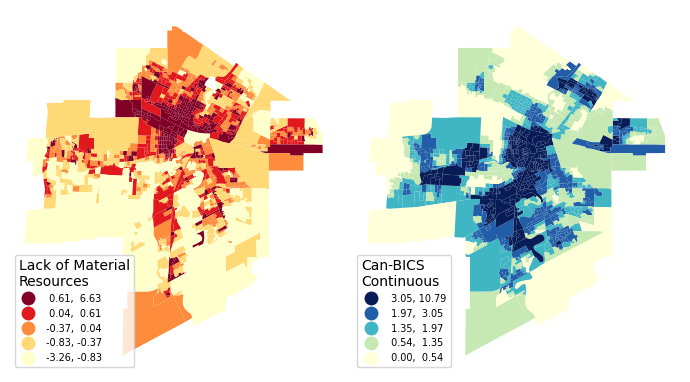

In [89]:
fig, ax = plt.subplots(ncols=2, figsize=(7,6))

gdf.plot(
    column = "material_resources_DA16", 
    cmap = 'YlOrRd', 
    scheme="Quantiles", 
    legend = True,
    ax=ax[0],
    legend_kwds = {
        "loc": "lower left",
        "fontsize": 7,
        "title": "Lack of Material\nResources",
        "alignment": "left",
        "reverse": True
    }
).set_axis_off();

gdf.plot(
    column = "CBICS_cont", 
    cmap = 'YlGnBu', 
    scheme="Quantiles", 
    legend = True,
    ax=ax[1],
    legend_kwds = {
        "loc": "lower left",
        "fontsize": 7,
        "title": "Can-BICS\nContinuous",
        "alignment": "left",
        "reverse": True
    }
).set_axis_off();

plt.tight_layout()

## Bivariate Classifications

I'll be focusing 3x3 classifications, but you could change this to any set dimension.

In [87]:
mapclassify.Quantiles(gdf["material_resources_DA16"], k = 3).bins

array([-0.53841907,  0.20459239,         nan])

In [88]:
mapclassify.Quantiles(gdf["CBICS_cont"], k = 3).bins

array([ 1.14533389,  2.24692905, 10.78995891])

We'll have to write a custom function to classify the data. Here's an example of such that would work for a single row of data. It reads in an `x` and `y` value and an array of bins for each. It returns a joint classification for 

In [99]:
gdf['x_group'] = gdf[['material_resources_DA16']].apply(mapclassify.Quantiles.make(rolling=True, k = 3))
gdf['y_group'] = gdf[['CBICS_cont']].apply(mapclassify.Quantiles.make(rolling=False, k = 3))
gdf['bi_group'] = gdf['x_group'].astype(str) + "-" + gdf['y_group'].astype(str)

In [100]:
gdf

,dauid,Population,PRUID,PRNAME,CDUID,CDNAME,CSDUID,CSDNAME,CMAUID,CMANAME,...,immigration_vismin_q_DA16,households_dwellings_DA16,material_resources_DA16,age_labourforce_DA16,immigration_vismin_DA16,pop2016,bivariateClassify,x_group,y_group,bi_group
0,46110001,1929.0,46,Manitoba,4611,Division No. 11,4611040,Winnipeg,602,Winnipeg,...,5.0,1.105539,-0.349423,0.452881,1.960440,1929,1-0,1,0,1-0
1,46110002,1643.0,46,Manitoba,4611,Division No. 11,4611040,Winnipeg,602,Winnipeg,...,5.0,-1.171813,-0.747839,-0.731954,1.521316,1643,0-0,0,0,0-0
2,46110003,597.0,46,Manitoba,4611,Division No. 11,4611040,Winnipeg,602,Winnipeg,...,4.0,-0.912090,-0.321103,-0.320267,0.670577,597,1-0,1,0,1-0
3,46110004,411.0,46,Manitoba,4611,Division No. 11,4611040,Winnipeg,602,Winnipeg,...,4.0,-0.678497,-0.958393,1.038513,0.155654,411,0-0,0,0,0-0
4,46110005,1020.0,46,Manitoba,4611,Division No. 11,4611040,Winnipeg,602,Winnipeg,...,4.0,1.087344,0.420112,0.465715,0.541806,1020,2-0,2,0,2-0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1113,46111225,590.0,46,Manitoba,4611,Division No. 11,4611040,Winnipeg,602,Winnipeg,...,5.0,1.746610,-1.026158,-0.934391,2.032429,590,0-1,0,1,0-1
1114,46111226,1333.0,46,Manitoba,4611,Division No. 11,4611040,Winnipeg,602,Winnipeg,...,4.0,1.094493,-1.075897,1.818808,0.381926,1333,0-2,0,2,0-2
1115,46111227,904.0,46,Manitoba,4611,Division No. 11,4611040,Winnipeg,602,Winnipeg,...,4.0,-1.288069,-0.908210,-0.756085,0.602611,904,0-2,0,2,0-2
1116,46111228,1009.0,46,Manitoba,4611,Division No. 11,4611040,Winnipeg,602,Winnipeg,...,5.0,-0.937663,-0.964629,0.099649,0.762788,1009,0-0,0,0,0-0


In [72]:
def bivariateClassify(x, y, x_bins, y_bins):
    # if either value is NaN, just return
    if math.isnan(x) or math.isnan(y): 
        return 'missing'
    else:
        len_x = len(x_bins)
        len_y = len(y_bins)
        i = 0
        while i < len_x:
            if x <= x_bins[i]:
                x1 = i
                break
            i += 1
        j = 0
        while j < len_y:
            if y <= y_bins[j]:
                y1 = j
                break
            j += 1
        return(str(i) + "-" + str(j))

Now let's apply this function to our dataset. We are inputting the `x` and `y` columns that we're interested in, as well as the the middle breaks.

In [60]:
gdf["bivariateClassify"] = gdf.apply(
    lambda row: bivariateClassify(
        row['material_resources_DA16'], row['CBICS_cont'], [-0.54,  0.20], [1.15,  2.25] 
    ), axis=1
)

0      -0.349423
1      -0.747839
2      -0.321103
3      -0.958393
4       0.420112
          ...   
1113   -1.026158
1114   -1.075897
1115   -0.908210
1116   -0.964629
1117   -0.698942
Name: material_resources_DA16, Length: 1118, dtype: float64


Let's see if this worked! Here are 5 random rows that we can double check

In [71]:
gdf[["dauid","material_resources_DA16","CBICS_cont","bivariateClassify"]].sample(5)

,dauid,material_resources_DA16,CBICS_cont,bivariateClassify
1044,46111148,1.800378,0.838761,2-0
981,46111078,0.503700,0.329173,2-0
309,46110328,0.736293,1.704119,2-1
1091,46111198,-0.219527,1.468864,1-1
732,46110801,1.048071,1.127942,2-0


## Bivariate Colours

Now that we've classified our data, we can assign colours and make a map! There are 

(img colour scheme e.g.)

Let's try to make a simple map using `gpd.plot()` based on our classified data, and one of these colour schemes

## More Resources on Bivariate Choropleth Maps

- [Wikipedia page on multivariate maps](https://en.wikipedia.org/wiki/Multivariate_map)
- 
